# Udara Peiris' calibration

## Packages

In [38]:
import requests
import pandas as pd
import xlrd
import os
import numpy as np

from scipy.optimize import fsolve
from scipy.stats import percentileofscore
import matplotlib.pyplot as plt

## Path and working directory

In [39]:
ROOT = os.path.dirname(os.getcwd())

PATH_DATA = os.path.join(ROOT, 'data')

print(PATH_DATA)

c:\Users\Maude\OneDrive\Documents\etudes\UZH\PhD\2nd year\first semester\calibration in macroeconomics\project\Udara\data


## External estimation of parameters

### GDP growth

5-year GDP growth based on annual GDP per capita in Argentina from the World Bank

In [40]:
# open excel file

df_GDP = pd.read_excel(os.path.join(PATH_DATA, 'GDP_per_capita - Argentina - WB.xlsx'))

#clean database

## delete the last 5 rows because only NaN values
df_GDP = df_GDP.iloc[:-5]

## delete the columns from 1960 to 1982
columns_to_drop = [f"{year} [YR{year}]" for year in range(1960, 1983)]
df_GDP = df_GDP.drop(columns=columns_to_drop)

## convert from wide format to long format
df_long = pd.melt(df_GDP, id_vars=['Country Name', 'Series Name'], var_name='Year', value_name='Value')

## delete the first three columns because useless information as only one country and one variable
df_long = df_long.drop(columns=['Country Name', 'Series Name'])

## delete the first two rows because useless information as only one country and one variable
df_long = df_long.iloc[2:]

## rename the column 'Value' to 'GDP per capita'
df_long = df_long.rename(columns={'Value': 'GDP per capita'})

## change the format of the 'Year' variable
df_long['Year'] = df_long['Year'].str.extract(r'(\d{4})').astype(int)

## create the 'GDP_growth_5' variable
df_long['GDP_growth_5'] = (df_long['GDP per capita'] - df_long['GDP per capita'].shift(5)) / df_long['GDP per capita'].shift(5)

# compute the 25th and 75th percentiles of the 'GDP_growth_5' variable between 1988 and 2001
## Filter the DataFrame for the years between 1988 and 2001
df_filtered = df_long[(df_long['Year'] >= 1988) & (df_long['Year'] <= 2001)]

## Create a vector with the GDP_growth_5 values
gdp_growth_5_vector = df_filtered['GDP_growth_5'].dropna().values

## Calculate the 25th and 75th percentiles
percentile_25 = np.percentile(gdp_growth_5_vector, 25)
percentile_75 = np.percentile(gdp_growth_5_vector, 75)

# Print the percentiles
print(f"the 25th percentile of the 5 year GDP growth between 1988 and 2001: {percentile_25}")
print(f"the 75th percentile of the 5 year GDP growth between 1988 and 2001: {percentile_75}")



the 25th percentile of the 5 year GDP growth between 1988 and 2001: 0.047384516851069064
the 75th percentile of the 5 year GDP growth between 1988 and 2001: 0.6934000884280214


GDP shock based on world GDP per capita growth

In [41]:
df_growth = pd.read_excel(os.path.join(PATH_DATA, 'GDP_growth - world - WB.xls'), sheet_name=0, header=0)

# delete the first two rows
df_growth = df_growth.iloc[2:]

# Define the columns to keep
columns_to_keep = ['Country Name', 'Country Code', 'Indicator Name', "2001", "2002", "2003", "2004", "2005"]

df_growth=df_growth[columns_to_keep]

# Create a new column 'average' with the average of columns 2001, 2002, 2003, 2004, 2005 for each row
df_growth['average'] = df_growth[['2001', '2002', '2003', '2004', '2005']].mean(axis=1)

# Handle NaN values by dropping rows with NaN in the 'average' column
df_growth = df_growth.dropna(subset=['average'])

# Print basic statistics of the 'average' column
print(df_growth['average'].describe())

# Find the percentile rank of the Argentinian average GDP growth
average_ARG = df_growth.loc[df_growth['Country Code'] == "ARG", 'average'].values
percentile_rank = percentileofscore(df_growth['average'], average_ARG)

# Calculate the 90th percentile of the 'average' column
percentile_90 = np.percentile(df_growth['average'], 89)

percentile_90

count    250.000000
mean       2.808581
std        3.097591
min       -8.080796
25%        1.143330
50%        2.439735
75%        3.975953
max       22.731930
Name: average, dtype: float64


np.float64(6.002092843275176)

GDP shock based on upper middle income countries like Argentina

In [42]:
df_classification = pd.read_excel(os.path.join(PATH_DATA, 'World_Bank_classification.xlsx'), sheet_name=0, header=0)

#keep only the columns "Code" and "Income group"
df_classification = df_classification[['Code', 'Income group']]

# Merge the df_growth and df_classification DataFrames
df_merged = pd.merge(df_growth, df_classification, left_on='Country Code', right_on='Code')

# keep only if income group is "Low income" or "Lower middle income"
df_merged = df_merged[(df_merged['Income group'] == 'Upper middle income')]

print(df_merged['average'].describe())

# Find the percentile rank of the Argentinian average GDP growth
average_ARG = df_merged.loc[df_merged['Country Code'] == "ARG", 'average'].values
percentile_rank = percentileofscore(df_merged['average'], average_ARG)

print(percentile_rank)

# Calculate the 90th percentile of the 'average' column
growth_h = np.percentile(df_merged['average'], 100-percentile_rank/1.5)

growth_h

count    53.000000
mean      3.889023
std       4.096473
min      -1.252327
25%       1.458500
50%       3.036128
75%       4.634298
max      22.731930
Name: average, dtype: float64
[18.86792453]


array([8.25336824])

## Calibration: Internal Estimation of Parameter

I will calibrate the bargaining power of the sovereign θ


In [43]:
# Initialization of external parameters
   
beta = 0.82                      # time discount factor
sigma = 2                        # risk aversion coefficient
g_l = (1+average_ARG/100)**5-1   # growth rate of the low state
g_h = (1+growth_h/100)**5-1      # growth rate of the high state (should take evidence from countries doing well)
y_0 = 1                          # output in time 0
y_l = 1+g_l                      # output of the low state
y_h = 1+g_h                      # output of the high state
kappa = 0.32                     # loss of output (quarterly 2%)

print(g_l, g_h)

[0.06242202] [0.48664437]


In [44]:
# Creation of grid for the believed haircut and for the bargaining power

delta_b = np.linspace(0, 1, 101) # to change later for 101 instead of 11
theta = np.linspace(0, 1, 11)

### Solving Household Problem

In [45]:
# price in time 0, q_0
q_0 = beta*(1-delta_b/2)
q_0

array([0.82  , 0.8159, 0.8118, 0.8077, 0.8036, 0.7995, 0.7954, 0.7913,
       0.7872, 0.7831, 0.779 , 0.7749, 0.7708, 0.7667, 0.7626, 0.7585,
       0.7544, 0.7503, 0.7462, 0.7421, 0.738 , 0.7339, 0.7298, 0.7257,
       0.7216, 0.7175, 0.7134, 0.7093, 0.7052, 0.7011, 0.697 , 0.6929,
       0.6888, 0.6847, 0.6806, 0.6765, 0.6724, 0.6683, 0.6642, 0.6601,
       0.656 , 0.6519, 0.6478, 0.6437, 0.6396, 0.6355, 0.6314, 0.6273,
       0.6232, 0.6191, 0.615 , 0.6109, 0.6068, 0.6027, 0.5986, 0.5945,
       0.5904, 0.5863, 0.5822, 0.5781, 0.574 , 0.5699, 0.5658, 0.5617,
       0.5576, 0.5535, 0.5494, 0.5453, 0.5412, 0.5371, 0.533 , 0.5289,
       0.5248, 0.5207, 0.5166, 0.5125, 0.5084, 0.5043, 0.5002, 0.4961,
       0.492 , 0.4879, 0.4838, 0.4797, 0.4756, 0.4715, 0.4674, 0.4633,
       0.4592, 0.4551, 0.451 , 0.4469, 0.4428, 0.4387, 0.4346, 0.4305,
       0.4264, 0.4223, 0.4182, 0.4141, 0.41  ])

In [46]:
# price in time 1, q_1
q_1 = beta
q_1

0.82

[0.15970039 0.16137707 0.16308039 0.16481083 0.16656892 0.16835516
 0.17017009 0.17201424 0.17388816 0.17579238 0.17772749 0.17969403
 0.18169259 0.18372375 0.18578809 0.18788622 0.19001874 0.19218625
 0.19438938 0.19662873 0.19890494 0.20121862 0.20357043 0.20596098
 0.20839092 0.21086088 0.2133715  0.21592342 0.21851726 0.22115366
 0.22383325 0.22655665 0.22932446 0.23213729 0.23499572 0.23790034
 0.24085171 0.24385037 0.24689685 0.24999164 0.25313523 0.25632805
 0.25957054 0.26286307 0.26620599 0.26959961 0.27304417 0.2765399
 0.28008696 0.28368544 0.28733539 0.29103679 0.29478954 0.29859347
 0.30244834 0.30635382 0.31030949 0.31431484 0.31836926 0.32247203
 0.32662234 0.33081926 0.33506173 0.33934859 0.34367855 0.3480502
 0.35246197 0.35691219 0.36139905 0.36592058 0.37047471 0.3750592
 0.37967168 0.38430965 0.38897049 0.39365141 0.39834953 0.40306183
 0.40778517 0.4125163  0.41725187 0.42198843 0.42672244 0.43145028
 0.43616826 0.44087264 0.44555962 0.45022537 0.45486604 0.4594777

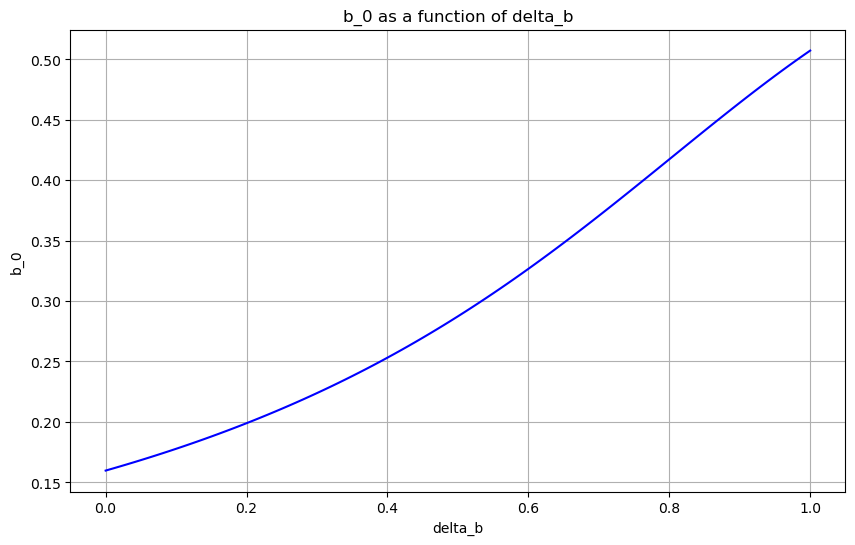

In [47]:
# solve for b_0

def HH_foc_b0(b_0, delta_b, q_0):
    LHS = (2-delta_b)*(y_0 + q_0*b_0 )**(-sigma)
    RHS_1 = (1-delta_b)*(y_l + beta*(1-delta_b)/(1+beta)*b_0 - (1-delta_b)*b_0)**(-sigma)
    RHS_2 = (y_h-b_0/(1+beta))**(-sigma)
    return LHS - RHS_1 - RHS_2

# Initial guess for the root
initial_guess = 0.5

# Vectorized function to solve for the root for each combination of delta_b and q_0
def solve_for_roots(delta_b, q_0, initial_guess):
    # Define a wrapper function for fsolve that only takes b_0 as input
    def wrapper(delta_b, q_0):
        return fsolve(HH_foc_b0, initial_guess, args=(delta_b, q_0))[0]
    
    # Apply the wrapper function to each combination of delta_b and q_0
    b_0 = np.array([wrapper(delta_b, q_0) for delta_b, q_0 in zip(delta_b, q_0)])
    return b_0

# Solve for the roots
b_0 = solve_for_roots(delta_b, q_0, initial_guess)
print(b_0)

# Plot b_0 as a function of delta_b
plt.figure(figsize=(10, 6))
plt.plot(delta_b, b_0, linestyle='-', color='b')
plt.xlabel('delta_b')
plt.ylabel('b_0')
plt.title('b_0 as a function of delta_b')
plt.grid(True)
plt.show()

    


In [48]:
# consumption in time 0, c_0

c_0 = y_0 + q_0*b_0
c_0

array([1.13095432, 1.13166755, 1.13238866, 1.13311771, 1.13385478,
       1.13459995, 1.13535329, 1.13611487, 1.13688476, 1.13766302,
       1.13844971, 1.1392449 , 1.14004865, 1.140861  , 1.141682  ,
       1.1425117 , 1.14335014, 1.14419735, 1.14505335, 1.14591818,
       1.14679184, 1.14767435, 1.1485657 , 1.14946588, 1.15037489,
       1.15129268, 1.15221923, 1.15315448, 1.15409837, 1.15505083,
       1.15601178, 1.1569811 , 1.15795869, 1.1589444 , 1.15993809,
       1.16093958, 1.16194869, 1.1629652 , 1.16398889, 1.16501948,
       1.16605671, 1.16710026, 1.1681498 , 1.16920496, 1.17026535,
       1.17133055, 1.17240009, 1.17347348, 1.17455019, 1.17562966,
       1.17671127, 1.17779437, 1.17887829, 1.17996228, 1.18104558,
       1.18212735, 1.18320672, 1.18428279, 1.18535458, 1.18642108,
       1.18748122, 1.18853389, 1.18957793, 1.1906121 , 1.19163516,
       1.19264578, 1.19364261, 1.19462422, 1.19558916, 1.19653595,
       1.19746302, 1.19836881, 1.1992517 , 1.20011004, 1.20094

### Solving Nash Bargaining

In [49]:
# utility function

def utility(c):
    return c**(1-sigma)/(1-sigma)
    #return np.log(c)

utility(0.5)



-2.0

In [50]:
# omega function

def omega(delta_l, theta, b_0):
    HS = ((1+beta)*utility(y_l - (1-delta_l)/(1+beta)*b_0)-utility(y_l)-beta*utility((1-kappa)*y_l))**theta
    FS = (b_0*(1-delta_l))**(1-theta)
    return HS*FS

# grid for delta_l and theta
delta_l = np.linspace(0, 1, 101)
theta_b = np.linspace(0, 1, 11)

#create a meshgrid for delta_l and theta
delta_L, theta_B, B_0 = np.meshgrid(delta_l, theta_b, b_0, indexing='ij')

# matrix for omega
m_omega = omega(delta_L, theta_B, B_0)

# Find the highest value for each combination of theta_B and B_0

max_indices = np.argmax(m_omega, axis=0) 

# Convert indices to corresponding delta_L values
max_delta_L_values = delta_l[max_indices]

print(max_delta_L_values)
max_delta_L_values.shape[0]



[[0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 ...
 [0.52 0.53 0.53 ... 0.   0.   0.  ]
 [0.75 0.76 0.76 ... 0.   0.   0.  ]
 [1.   1.   1.   ... 1.   1.   1.  ]]


C:\Users\Maude\AppData\Local\Temp\ipykernel_23284\1204235016.py:4: RuntimeWarning: invalid value encountered in power
  HS = ((1+beta)*utility(y_l - (1-delta_l)/(1+beta)*b_0)-utility(y_l)-beta*utility((1-kappa)*y_l))**theta


11

### Calibration of theta to target b_0/y_0

In [51]:
# rationale expectation

def delta_rational_2(m_max_delta_L_values, v_delta_l):
    m_delta_l = np.tile(v_delta_l, (m_max_delta_L_values.shape[0], 1))
    m_diff=abs(m_max_delta_L_values-m_delta_l)
    min_indices = np.argmin(m_diff, axis=1)
    v_delta_r= v_delta_l[min_indices]
    return v_delta_r, min_indices

delta_rational_2(max_delta_L_values, delta_l)[0]

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.48, 0.61, 0.62, 0.62, 1.  ])

In [52]:
def delta_rational(m_max_delta_L_values, v_delta_l):
    m_delta_l = np.tile(v_delta_l, (m_max_delta_L_values.shape[0], 1))
    m_diff=abs(m_max_delta_L_values-m_delta_l)

    # if several minimum, take the one in the middle

    # Function to find the middle index of minimum values
    def middle_index_of_min(arr):
        min_value = np.min(arr)
        min_indices = np.where(arr == min_value)[0]
        middle_index = min_indices[len(min_indices) // 2]
        return middle_index

    adjusted_indices = np.apply_along_axis(middle_index_of_min, 1, m_diff).T  

    v_delta_r= v_delta_l[adjusted_indices]
    return v_delta_r, adjusted_indices

delta_rational(max_delta_L_values, delta_l)

(array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.49, 0.62, 0.62, 0.62, 1.  ]),
 array([  0,   0,   0,   0,   0,   0,  49,  62,  62,  62, 100]))

In [53]:
# target debt to GDP ratio, b_0/y_0

## open excel file
df = pd.read_excel(os.path.join(PATH_DATA, 'debt_to_GDP - Argentina - IMF.xls'), sheet_name=1)

## Define the years to keep
years_to_keep = [1996, 1997, 1998, 1999, 2000]

## Filter the DataFrame to keep only the rows where Year is in the specified list
df_0 = df[df['Year'].isin(years_to_keep)]
df_0

## Calculate the average of the 'debt_to_GDP' variable
target_b_0_y_0 = df_0['debt_to_GDP'].mean()
target_b_0_y_0


np.float64(37.118)

In [54]:
#b_0/y_0 for each delta in delta_rational
min_indices=delta_rational(max_delta_L_values, delta_l)[1]
print(b_0[min_indices])

#closest b_0/y_0 to target_b_0_y_0

abs_diff = abs(b_0[min_indices]*100-target_b_0_y_0)

# Find the minimum value
min_value = np.min(abs_diff)

# Find all indices of the minimum value
min_indices_several = np.where(abs_diff == min_value)[0]

# Select the middle index of the minimum values
middle_index = min_indices_several[len(min_indices_several) // 2]

# Assign the middle index to min_indices_target
min_indices_target = middle_index

#min_indices_target = np.argmin(abs(b_0[min_indices]*100-target_b_0_y_0))
cali_b_0_y_0=b_0[min_indices][min_indices_target]
cali_b_0_y_0

min_indices[min_indices_target]


[0.15970039 0.15970039 0.15970039 0.15970039 0.15970039 0.15970039
 0.28368544 0.33506173 0.33506173 0.33506173 0.50721152]


np.int64(62)

In [55]:
# Solution

print(f"The target debt to GDP ratio is {target_b_0_y_0}")
print(f"the calibrated debt to GDP ratio is {cali_b_0_y_0}")
print(f"The rationale believed haircut is {delta_rational(max_delta_L_values, delta_l)[0][min_indices_target]} and the optimal haircut is {max_delta_L_values[min_indices_target, min_indices[min_indices_target] ]}")
print(f"The Nash bargaining power is {theta_b[min_indices_target]}")

The target debt to GDP ratio is 37.118
the calibrated debt to GDP ratio is 0.3350617299218259
The rationale believed haircut is 0.62 and the optimal haircut is 0.77
The Nash bargaining power is 0.8
